# Content Based Recommendations System

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [87]:
songs = pd.read_csv("data.csv")
songs.head(4)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109


In [88]:
songs.shape
songs.isna().sum()

valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64

In [89]:
viz_songs=songs.drop(columns=['id', 'name', 'artists', 'release_date', 'year'])
viz_songs.head()

,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
0,0.0594,0.982,0.279,831667,0.211,0,0.878000,10,0.665,-20.096,1,4,0.0366,80.954
1,0.9630,0.732,0.819,180533,0.341,0,0.000000,7,0.160,-12.441,1,5,0.4150,60.936
2,0.0394,0.961,0.328,500062,0.166,0,0.913000,3,0.101,-14.850,1,5,0.0339,110.339
3,0.1650,0.967,0.275,210000,0.309,0,0.000028,5,0.381,-9.316,1,3,0.0354,100.109
4,0.2530,0.957,0.418,166693,0.193,0,0.000002,3,0.229,-10.096,1,2,0.0380,101.665


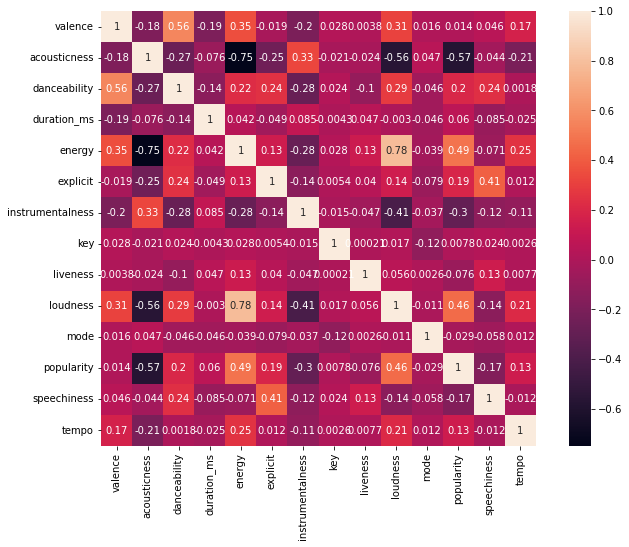

In [90]:
#EDA
plt.subplots(figsize=(12, 8))
sns.heatmap(viz_songs.corr(), annot=True, square=True)
plt.show()

In [91]:
def normalize_column(col):
    songs[col] = (songs[col] - songs[col].min()) / (songs[col].max() - songs[col].min())    

num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = songs.select_dtypes(include=num_types)

for col in num.columns:
  normalize_column(col)
# songs.head(3)

num_2 = viz_songs.select_dtypes(include=num_types)

for col in num_2.columns:
  normalize_column(col)
viz_songs.head()

,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
0,0.0594,0.982,0.279,831667,0.211,0,0.878000,10,0.665,-20.096,1,4,0.0366,80.954
1,0.9630,0.732,0.819,180533,0.341,0,0.000000,7,0.160,-12.441,1,5,0.4150,60.936
2,0.0394,0.961,0.328,500062,0.166,0,0.913000,3,0.101,-14.850,1,5,0.0339,110.339
3,0.1650,0.967,0.275,210000,0.309,0,0.000028,5,0.381,-9.316,1,3,0.0354,100.109
4,0.2530,0.957,0.418,166693,0.193,0,0.000002,3,0.229,-10.096,1,2,0.0380,101.665


In [93]:
#K-Means clustering for genre classification
from sklearn.cluster import KMeans

km = KMeans(n_clusters=12)
cat = km.fit_predict(num)
songs['cat'] = cat
normalize_column('cat')

In [ ]:
songs.cat[:10]

0    0.181818
1    0.090909
2    0.727273
3    0.090909
4    0.909091
5    0.727273
6    0.909091
7    0.454545
8    0.909091
9    0.090909
Name: cat, dtype: float64

In [95]:
#finds song ID i.e index of song in the csv
def find_songId(title):
    song_id=songs.loc[songs["name"]==title].index[0]
    return song_id

def find_songVector(title):
    song_id=find_songId(title)
    print(viz_songs.iloc[song_id:song_id+1,:].shape)
    
    return viz_songs.iloc[song_id:song_id+1,:]
#finds reccomendations using a given song title
def find_recommendations(title):
    
    songId=find_songId(title)
    song_vec=find_songVector(title)
    sim=cosine_similarity(viz_songs,song_vec)
    print("SHAPE ")
    print(sim.shape)
    scores=list(enumerate(sim))
    sorted_scores=sorted(scores,key=lambda x:x[1],reverse=True)  #sorts all the songs in the list in reverse order (decreasing order)
    sorted_scores=sorted_scores[1:]                               #skips the first index as it is the same song with highest similarity
    # print(len(sorted_scores))
    # print(scores)
    rec_songs=[]
    for i in range(0,5):
        indx=sorted_scores[i][0]
        print(sorted_scores[i])
        rec_songs.append(songs.loc[indx]["name"]+" by "+songs.loc[indx]["artists"])       #adds all song title according to the scores found
    return rec_songs #returns the songs


find_recommendations("Homicide (feat. Eminem)")

(1, 14)
SHAPE 
(170653, 1)
(74596, array([1.]))
(108400, array([1.]))
(140474, array([1.]))
(90298, array([1.]))
(37740, array([1.]))


["Guys My Age by ['Hey Violet']",
 "Go Go by ['BTS']",
 "Body Back (feat. Maia Wright) by ['Gryffin', 'Maia Wright']",
 "Lights - Single Version by ['Ellie Goulding']",
 "It Ain't My Fault by ['Brothers Osborne']"]

In [97]:
class SpotifyRecommender():
    def __init__(self, rec_data):
        #our class should understand which data to work with
        self.rec_data_ = rec_data
    
    #if we need to change data
    def change_data(self, rec_data):
        self.rec_data_ = rec_data
    # num_types = ['string']
    # non_num_col=songs.select_dtypes(include=num_types)

    #function which returns recommendations, we can also choose the amount of songs to be recommended
    def get_recommendations(self, song_name, amount=1):
        distances = []
        #choosing the data for our song
        song = self.rec_data_[(self.rec_data_.name.str.lower() == song_name.lower())].head(1).values[0]
        #dropping the data with our song
        res_data = self.rec_data_[self.rec_data_.name.str.lower() != song_name.lower()]
        for r_song in tqdm(res_data.values):
            dist = 0
            for col in np.arange(len(res_data.columns)):
                #indeces of non-numerical columns
                if not col in [3, 8, 14,16]:
                    #calculating the manhettan distances for each numerical feature
                    dist = dist + np.absolute(float(song[col]) - float(r_song[col]))
            distances.append(dist)
        res_data['distance'] = distances
        #sorting our data to be ascending by 'distance' feature
        res_data = res_data.sort_values('distance')
        columns = ['artists', 'name']
        return res_data[columns][:amount]

In [98]:
recommender = SpotifyRecommender(songs)

In [99]:
recommender.get_recommendations("Homicide (feat. Eminem)", 5)

100%|██████████| 170652/170652 [00:04<00:00, 40938.01it/s]


,artists,name
91981,"['Logic', 'Eminem']",Homicide
124215,['Kevin Gates'],Imagine That
140665,"['Bad Bunny', 'Anuel AA']",Está Cabrón Ser Yo
56607,['YoungBoy Never Broke Again'],No Smoke
19349,"['Eminem', 'Joyner Lucas']",Lucky You (feat. Joyner Lucas)
